In [16]:
import pandas as pd
import plotly.express as px
import shapely.wkt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import descartes

In [17]:
df = pd.read_csv('../Data/bikes_station_location.csv')
df.loc[0]

Station #                               1000
Station Name        Liberty Ave & Stanwix St
NumRacks                                  16
Latitude                           40.441326
Longitude                         -80.004679
coordinates     POINT (-80.004679 40.441326)
Name: 0, dtype: object

In [18]:
df = df.rename(columns={"Station Name": "Station_Name"})

for row in range(len(df)):
    df.at[row,"coordinates"] = shapely.wkt.loads(df.loc[row]["coordinates"])

### Location of Bike Stations
Size of each circle for the bike station location represents the number of bike racks at that station

In [20]:
fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="Station_Name", size="NumRacks",
                  color_continuous_scale=px.colors.diverging.Picnic, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

# Annotating

In [7]:
#get the 2010 census tract neighborhoods in Pittsburgh
cenTract = gpd.read_file('../Data/2010_Census_Tracts/a36fc9b1-4e53-4fd1-80fb-db1554e213422020328-1-nbfxcj.l6b8.shp')
cenTract.head(1)

,objectid,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,aland10,...,tractce10_,cnt_tractc,sum_lowmod,sum_lowm_1,lowmodperc,lowmodpe_1,cdbg2018,Shape__Are,Shape__Len,geometry
0,1,42,003,040500,1,420030405001,Block Group 1,G5030,S,268195,...,040500,2,2775,2985,92.964824,92.96,Yes,5.079492e+06,10442.03645,"POLYGON ((-79.95304 40.44203, -79.95302 40.442..."


In [8]:
cenTractPHC = pd.read_csv('../Data/cenTractPHC.csv')

In [9]:
#for every point (bike station), check if if it exists in that polygon (census tract)
df.at[80,"coordinates"] = Point(-79.92787,40.4677154)
for row in range(len(df)):
    for tract in range(len(cenTract)):
        if df.loc[row]["coordinates"].within(cenTract.loc[tract]["geometry"]):
            df.at[row,"tractce10"] = cenTract.loc[tract]["tractce10"] 

### Plot by census tract

In [10]:
df['tractce10'] = df.tractce10.astype(str)

fig = px.scatter_mapbox(df, lat="Latitude", lon="Longitude", color="tractce10", size="NumRacks",
                color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=15, zoom=10,
                  mapbox_style="carto-positron")
fig.show()

In [11]:
df.to_csv('../Data/stations_census_tracts.csv', index=False)

In [85]:
inc_df = pd.read_csv('../Data/IncomeCensusData.csv')
inc_df = inc_df.rename(columns={"CensusTract": "tractce10", '2015TractMedianHouseHoldIncome': '2015_tract_med_hhincome'})
inc_df = inc_df.astype({'tractce10': 'str'})

for i in range(len(inc_df)):
    tract = inc_df.loc[i]['tractce10']
    if len(tract) == 5:
        inc_df.at[i,'tractce10'] = str(0) + inc_df.loc[i]['tractce10']

combo_df = df.merge(inc_df, on='tractce10')
combo_df.head(1)

,Station #,Station_Name,NumRacks,Latitude,Longitude,coordinates,tractce10,TractIncomeLevel,2015_tract_med_hhincome
0,1000,Liberty Ave & Stanwix St,16,40.441326,-80.004679,POINT (-80.00467900000001 40.441326),020100,Upper,67750.0


In [86]:
fig = px.scatter_mapbox(combo_df, lat="Latitude", lon="Longitude", 
                        color="tractce10", 
                        size="NumRacks",
                        hover_name="Station_Name", 
                        hover_data={"tractce10":True, 
                                    "2015_tract_med_hhincome":True,
                                   "Latitude": False,
                                   "Longitude": False},
                        color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=15, zoom=10,
                        mapbox_style="carto-darkmatter")
fig.show()

### Counting Number of Stations per Tract

In [87]:
data = []
count = 0

for row in range(len(cenTract)):
    data.append([cenTract.loc[row]['tractce10'], count])
    
tracts_df = pd.DataFrame(data, columns = ['tractce10', 'count'])

for row in range(len(cenTract)):
    count = 0
    cen = cenTract.loc[row]['tractce10']
#     print("Census Tract: ", cen)
    for row2 in range(len(df)):
        dfcen = df.loc[row2]['tractce10']
#         print("Current Row Tract: ", dfcen)
        if cen == dfcen:
#             print("adding")
            count += 1
#             print("count is now: ", count)
#     print("End of dataframe - adding total")
#     print("total is ", count)
#     print(tracts_df.loc[tracts_df['tractce10'] == cen])
    idx = tracts_df.loc[tracts_df['tractce10'] == cen].index
    tracts_df.at[idx,'count'] = count
#     print("added")
#     print(tracts_df.loc[tracts_df['tractce10'] == cen])


### Mapping count of stations per census tract

/Users/katelyncmorrison/opt/anaconda3/envs/fair_demand_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




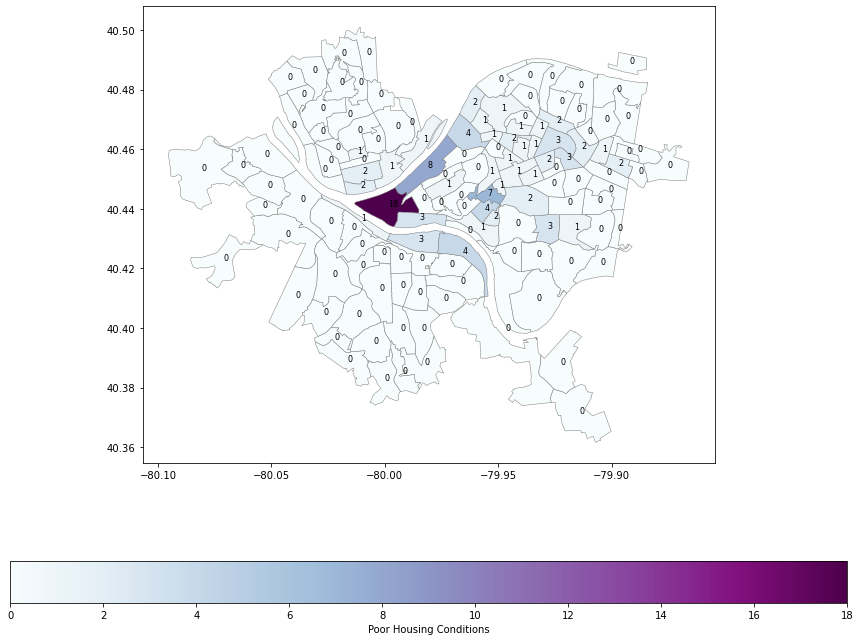

In [88]:
final_df = cenTract.merge(tracts_df, on='tractce10')

#find the centroids of each neighborhood for labeling
final_df["center"] = final_df["geometry"].centroid
map_points = final_df.copy()
map_points.set_geometry("center", inplace = True)
#plot the neighborhood ids on the map
final_df.plot(column="count", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Poor Housing Conditions",'orientation': "horizontal"})
    
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["count"]):
    texts.append(plt.text(x, y, label, fontsize = 8))

### Mapping Count Relative to Poor Housing Conditions

In [90]:
final_PHC_df = final_df.join(cenTractPHC['PPoorCon'])


for i in range(len(final_PHC_df)):
    print(final_PHC_df.loc[i]['tractce10'])

040500
040400
040200
030500
980000
020300
020100
262000
261500
261400
261200
260900
260700
563100
562400
981000
170200
180300
170600
010300
260200
180700
250900
562900
561900
130600
040900
562300
151700
151600
141400
141300
250300
241200
562000
080900
240600
220600
981800
080200
160800
101800
060300
080700
290400
981100
190300
101600
191100
191400
110600
141100
110200
101700
210700
980100
101100
140600
120400
191600
191700
101400
100500
090100
090200
090300
982200
191800
202300
563000
561600
561700
202200
980700
562700
562600
191900
080600
080400
070900
070800
300100
270800
981200
281400
281500
140500
290200
070600
070500
070300
060500
980600
140100
290100
051100
051000
050900
141000
140800
140400
191500
562500
310200
320400
140300
140200
271500
563200
192000
320600
320700
130400
130300
130200
270300
980400
481000
130100
120800
120700
980300
562800
120300
111500
310300
111400
111300
050600
980500
160900
050100
040600
270100
980900
250700
270400
980800


/Users/katelyncmorrison/opt/anaconda3/envs/fair_demand_prediction/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.




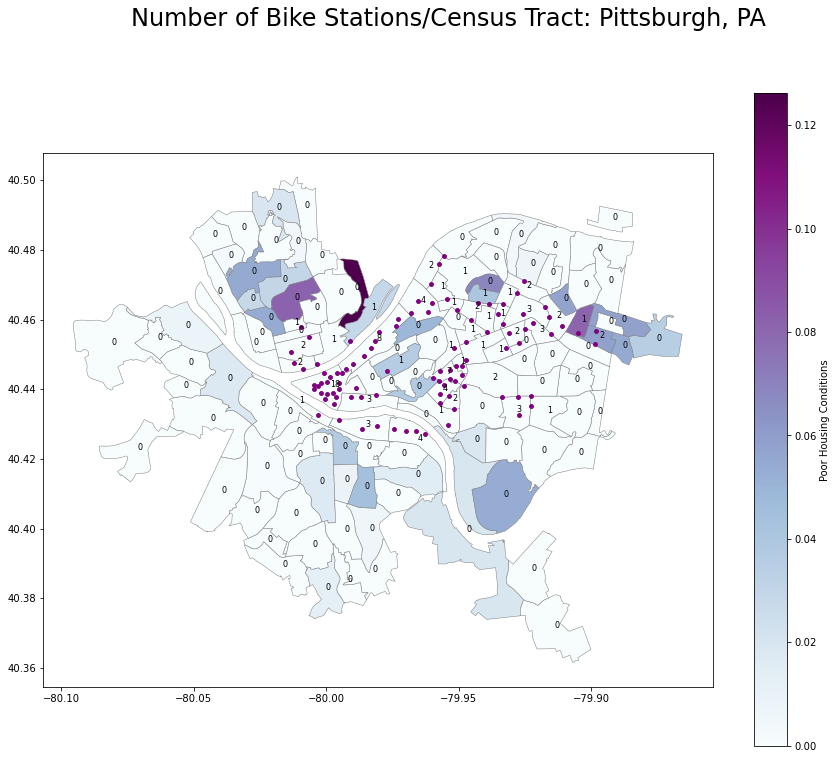

In [15]:
#find the centroids of each neighborhood for labeling
final_PHC_df["center"] = final_PHC_df["geometry"].centroid
map_points = final_PHC_df.copy()
map_points.set_geometry("center", inplace = True)

final_PHC_df.plot(column="PPoorCon", cmap='BuPu', figsize = (15, 12), edgecolor = "grey", linewidth = 0.5, legend=True, legend_kwds={'label': "Poor Housing Conditions",'orientation': "vertical"})
#now adding the bike station location data on top of this map. 
result = plt.scatter(combo_df['Longitude'], combo_df['Latitude'], 15, marker='o', color='Purple')
texts = []

for x, y, label in zip(map_points.geometry.x, map_points.geometry.y, map_points["count"]):
    texts.append(plt.text(x, y, label, fontsize = 8))
    
#save figure and label it
resultFig = result.get_figure()
resultFig.suptitle('Number of Bike Stations/Census Tract: Pittsburgh, PA', fontsize=24)
resultFig.savefig("../Results/stat_count_PHC.png")

#### number of racks in census tracts with poor housing conditions are 
12 + 5 + 6 + 7 + 8 = 38
#### how many racks total? 
1085
#### how many bike stations total? 
100
#### how many bikes total?
550
#### which census tracts are those 5 bike stations in? 
120700, 130300, 050100, 101700

In [19]:
total = 0
for i in range(len(combo_df)):
    total += combo_df.loc[i]['NumRacks']
    
print(total)

1085


In [61]:
upper_df = combo_df.loc[(combo_df['tractce10'] != '120700') & (combo_df['tractce10'] != '130300') & (combo_df['tractce10'] != '050100') & (combo_df['tractce10'] != '101700')]

### Modified Map
Below the map shows all bike stations that are not in census tracts with a significant percentage of poor housing conditions.

In [62]:
fig_upper = px.scatter_mapbox(upper_df, lat="Latitude", lon="Longitude", 
                        color="tractce10", 
                        size="NumRacks",
                        hover_name="Station_Name", 
                        hover_data={"tractce10":True, 
                                    "2015_tract_med_hhincome":True,
                                   "Latitude": False,
                                   "Longitude": False},
                        color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=15, zoom=10,
                        mapbox_style="carto-darkmatter")
fig_upper.show()

In [63]:
upper_df = upper_df.reset_index()
fixed_df = upper_df.loc[upper_df['2015_tract_med_hhincome'] > 0.0]
fixed_df = fixed_df.reset_index()
for i in range(len(fixed_df)):
    print(fixed_df.loc[i]['2015_tract_med_hhincome'])

67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
67750.0
41071.0
41071.0
41071.0
94643.0
94643.0
94643.0
94643.0
94643.0
94643.0
94643.0
94643.0
30543.0
33938.0
33938.0
50781.0
50781.0
53724.0
33816.0
49750.0
49750.0
51509.0
24308.0
24308.0
24308.0
21154.0
51703.0
51703.0
51703.0
51250.0
51250.0
54821.0
33929.0
119688.0
119688.0
21277.0
21277.0
17441.0
17441.0
17441.0
17441.0
32837.0
53241.0
53241.0
53241.0
53241.0
43750.0
43750.0
43750.0
25689.0
25689.0
37431.0
37431.0
37431.0
37431.0
67944.0
48000.0
48000.0
48000.0
26964.0
26196.0
16318.0
33400.0
33400.0
36944.0
40566.0
43750.0


In [64]:
fixed_df['2015_tract_med_hhincome'].mean()

52120.869047619046

In [65]:
fixed_df['2015_tract_med_hhincome'].min()

16318.0

In [66]:
fixed_df['2015_tract_med_hhincome'].max()

119688.0

The mean 2015 median household income for the census tracts that do not have poor housing condition is $52120.87

In [70]:
lower_df = combo_df.loc[(combo_df['tractce10'] == '120700') | (combo_df['tractce10'] == '130300') | (combo_df['tractce10'] == '050100') | (combo_df['tractce10'] == '101700')]

In [71]:
lower_df

,Station #,Station_Name,NumRacks,Latitude,Longitude,coordinates,tractce10,TractIncomeLevel,2015_tract_med_hhincome
68,1042,Centre Ave & Kirkpatrick St,12,40.445236,-79.976911,POINT (-79.976911 40.445236),050100,Low,17692.0
83,1063,Penn Ave & N Atlantic Ave,5,40.464605,-79.938760,POINT (-79.93876040000001 40.46460503),101700,Low,32163.0
84,1066,N Homewood Ave & Finance St (Homewood Station),8,40.453046,-79.898479,POINT (-79.89847897999999 40.45304583),130300,Moderate,13986.0
85,49321,Bennett St & Eccrue Way,7,40.456687,-79.898136,POINT (-79.89813565999999 40.45668686),130300,Moderate,13986.0
94,49311,Hamilton Ave & N Dallas Ave,6,40.456238,-79.905056,POINT (-79.90505576 40.45623787),120700,Moderate,19762.0


## Modified Map
The below map shows the five bike stations that are in census tracts with a significant percentage of poor housing conditions

In [37]:
fig_lower = px.scatter_mapbox(lower_df, lat="Latitude", lon="Longitude", 
                        color="tractce10", 
                        size="NumRacks",
                        hover_name="Station_Name", 
                        hover_data={"tractce10":True, 
                                    "2015_tract_med_hhincome":True,
                                   "Latitude": False,
                                   "Longitude": False},
                        color_discrete_sequence=px.colors.qualitative.Alphabet, size_max=15, zoom=10,
                        mapbox_style="carto-darkmatter")
fig_lower.show()

In [72]:
lower_df = lower_df.reset_index()
fixed_df = lower_df.loc[lower_df['2015_tract_med_hhincome'] > 0.0]
fixed_df = fixed_df.reset_index()

fixed_df['2015_tract_med_hhincome'].mean()

19517.8

The mean 2015 median household income for the census tracts that do not have poor housing condition is $19,517.80

In [73]:
fixed_df['2015_tract_med_hhincome'].min()

13986.0

In [74]:
fixed_df['2015_tract_med_hhincome'].max()

32163.0